# NLP tf-idf pipeline with cuML + Dask

In [1]:
%matplotlib inline
from dask_cuda import LocalCUDACluster
from dask.distributed import Client, wait
import dask_cudf
from cuml.feature_extraction.text import HashingVectorizer
from cuml.dask.feature_extraction.text import TfidfTransformer
import nltk
import cupy as cp
from tqdm import tqdm
import dask

### Import other utility functions for benchmarking purposes 

In [2]:
from utils import SimpleTimer, ResultsLogger, scale_workers
from utils import visualize_data_cuml as visualize_data

## Setting up the Dask cuda cluster

In [3]:
# # Create a local CUDA cluster
cluster = LocalCUDACluster(CUDA_VISIBLE_DEVICES="0,1,2,3,4,5,6,7", local_directory="/raid/tfidf_benchmark/dask", rmm_pool_size="28GB")
client = Client(cluster)

In [4]:
client

Connection method: Cluster object,Cluster type: LocalCUDACluster
Dashboard: http://127.0.0.1:8787/status,
Status: running,Using processes: True
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 8,Total memory: 0.98 TiB
Comm: tcp://127.0.0.1:38077,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 0.98 TiB
Comm: tcp://127.0.0.1:38115,Total threads: 1
Dashboard: http://127.0.0.1:44863/status,Memory: 125.97 GiB
Nanny: tcp://127.0.0.1:37435,


## Benchmarking Code

### Helper Functions

In [5]:
nltk.download('stopwords')
STOPWORDS = nltk.corpus.stopwords.words('english')
PUNCTUATIONS = ['!', '"', '#', '$', '%', '&', '(', ')', '*', '+', '-', '.',
                '/', '\\', ':', ';', '<', '=', '>', '?', '@', '[', ']', '^',
                '_', '`', '{', '|', '}', '\t','\n', "'", ",", '~' , '—']

def read_data(client, parquet_path):
    data = dask_cudf.read_parquet(parquet_path, columns=["review_body"], split_row_groups=3)
    data = client.persist(data)
    wait(data)
    print(data.shape[0].compute())
    return data


def text_preprocessor(data, client, column_name, PUNCTUATIONS,STOPWORDS):
    data = data[data[column_name].notnull()]
    data[column_name] = (data[column_name]
                         .str.lower()
                         .str.replace_tokens(
                             PUNCTUATIONS, [" "]*len(PUNCTUATIONS))
                         .str.replace_tokens(STOPWORDS, "")
                         .str.normalize_spaces()
                         .str.strip())
    data = client.persist(data)
    wait(data)
    print(data.shape[0].compute())
    return data


def hashing_vectorizer(data, client, column_name):
    vectorizer = HashingVectorizer(stop_words=None, preprocessor=None)
    # Meta is an empty dataframe matches the dtypes and columns of the output
    meta = dask.array.from_array(cp.sparse.csr_matrix(cp.zeros(1, dtype=cp.float32)))
    hashing_vectorized = data[column_name].map_partitions(vectorizer.fit_transform, meta=meta).astype(cp.float32)
    hashing_vectorized = client.persist(hashing_vectorized)
    wait(hashing_vectorized)
    hashing_vectorized.compute_chunk_sizes()
    print(hashing_vectorized.shape)
    return hashing_vectorized


def tfidf_transformer(data, client):
    multi_gpu_transformer = TfidfTransformer(client=client)
    result = multi_gpu_transformer.fit_transform(data)
    result = client.persist(result)
    wait(result)
    result.compute_chunk_sizes()
    print(result.shape)
    return result


def execute_full_pipeline(n, i, client, parquet_path, worker_counts=[1],
                            result_path="./results.csv"):
    sample_record = {"overall": 0, "data_read": 0, "hashing_vectorizer": 0,
                    "tfidf_transformer": 0, "data_preprocessing": 0, "nrows": 0}
    client.restart()
    with SimpleTimer() as timer:
        data = read_data(client, parquet_path)
    sample_record["data_read"] = timer.elapsed/1e9

    with SimpleTimer() as timer:
        data = text_preprocessor(data, client, "review_body", PUNCTUATIONS, STOPWORDS)
    sample_record["data_preprocessing"] = timer.elapsed/1e9

    with SimpleTimer() as timer:
        hashing_vectorized = hashing_vectorizer(data, client, "review_body")
    sample_record["hashing_vectorizer"] = timer.elapsed/1e9

    with SimpleTimer() as timer:
        result = tfidf_transformer(hashing_vectorized, client)
    sample_record["tfidf_transformer"] = timer.elapsed/1e9

    print(f"Workers:{n}, Sample Run:{i}, Finished loading data in {sample_record['data_read']}s")
    print(f"Workers:{n}, Sample Run:{i}, Finished preprocessing data in {sample_record['data_preprocessing']}s")
    print(f"Workers:{n}, Sample Run:{i}, Finished fitting HashVectorizer in {sample_record['hashing_vectorizer']}s")
    print(f"Workers:{n}, Sample Run:{i}, Finished fitting IDF Transformer in {sample_record['tfidf_transformer']}s")

    return data, result, sample_record

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/nfs/anirband/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
def performance_numbers(client, parquet_path, worker_counts=[1], samples=1, result_path="./results.csv"):
    """
    Main function to perform the performance sweep
    """
    results_logger = ResultsLogger(result_path)
    for n in worker_counts: 
        scale_workers(client, n)
        
        for i in tqdm(range(samples)): 
            with SimpleTimer() as overalltimer:
                data, result, sample_record = execute_full_pipeline(n, i, client, parquet_path, worker_counts=[1], result_path=result_path)
            sample_record["overall"]=overalltimer.elapsed/1e9
            sample_record["nrows"]=data.shape[0].compute()
            sample_record["n_workers"]=n
            sample_record["sample_run"]=i
            print(f"Workers:{n}, Sample Run:{i}, Finished executing full pipeline in {overalltimer.elapsed/1e9}s")
            results_logger.log(sample_record)
    results_logger.write()

In [7]:
#parquet_path = 's3://amazon-reviews-pds/parquet/product_category=Camera/*.parquet'
dataset = "Books"
#parquet_path = f'./data/product_category={dataset}'
parquet_path = f"/raid/amazon_reviews_dataset/product_category={dataset}"
samples = 5
worker_counts = [2,4,6,8]
result_path = f"./results/result_poc_nlp_dask_{dataset}_persist.csv"

In [8]:
%%time
performance_numbers(client, parquet_path=parquet_path, worker_counts=worker_counts, samples=samples, result_path=result_path)

  0%|                                                                                                                                                                                      | 0/5 [00:00<?, ?it/s]

20726160
20725971
# nnz: 0
(20725971, 1048576)
[I] [07:53:16.146309] [Delayed('_merge_stats_to_model-813893b2-626b-4561-b9a4-726917b940f7')]
[I] [07:53:16.150658] [Delayed('_merge_stats_to_model-e56a729c-dc17-4ab9-8c9b-ec46ecca3cc6')]
[I] [07:53:16.210694] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-813893b2-626b-4561-b9a4-726917b940f7>]
[I] [07:53:16.210928] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-e56a729c-dc17-4ab9-8c9b-ec46ecca3cc6>]
[I] [07:53:16.216555] [Delayed('_merge_stats_to_model-06d2bc0c-545b-4c04-bcc5-144fc65e305a')]


 20%|██████████████████████████████████▊                                                                                                                                           | 1/5 [00:44<02:57, 44.41s/it]

(20725971, 1048576)
Workers:2, Sample Run:0, Finished loading data in 5.0895142s
Workers:2, Sample Run:0, Finished preprocessing data in 18.540178819s
Workers:2, Sample Run:0, Finished fitting HashVectorizer in 16.29362533s
Workers:2, Sample Run:0, Finished fitting IDF Transformer in 1.15394484s
Workers:2, Sample Run:0, Finished executing full pipeline in 44.365918109s
20726160
20725971
# nnz: 0
(20725971, 1048576)
[I] [07:53:59.010989] [Delayed('_merge_stats_to_model-8e1d3a17-5770-463d-9084-e8453939046b')]
[I] [07:53:59.015094] [Delayed('_merge_stats_to_model-39ddeb09-cfc6-4e82-80ef-132d5d18fab6')]
[I] [07:53:59.078411] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-8e1d3a17-5770-463d-9084-e8453939046b>]
[I] [07:53:59.078614] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-39ddeb09-cfc6-4e82-80ef-132d5d18fab6>]
[I] [07:53:59.085929] [Delayed('_merge_stats_to_model-674d1b17-e3db-4271-8d48-3ea8e6d653db')]


 40%|█████████████████████████████████████████████████████████████████████▌                                                                                                        | 2/5 [01:27<02:10, 43.50s/it]

(20725971, 1048576)
Workers:2, Sample Run:1, Finished loading data in 3.18178013s
Workers:2, Sample Run:1, Finished preprocessing data in 18.522294681s
Workers:2, Sample Run:1, Finished fitting HashVectorizer in 16.099082448s
Workers:2, Sample Run:1, Finished fitting IDF Transformer in 1.194648918s
Workers:2, Sample Run:1, Finished executing full pipeline in 42.820689024s
20726160
20725971
# nnz: 0
(20725971, 1048576)
[I] [07:54:42.644564] [Delayed('_merge_stats_to_model-db17d6f7-5045-4a84-8d2e-2c4cd7cb8999')]
[I] [07:54:42.649168] [Delayed('_merge_stats_to_model-84ae04d3-fe17-4291-a274-c95e661fa74f')]
[I] [07:54:42.716200] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-db17d6f7-5045-4a84-8d2e-2c4cd7cb8999>]
[I] [07:54:42.716478] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-84ae04d3-fe17-4291-a274-c95e661fa74f>]
[I] [07:54:42.723606] [Delayed('_merge_stats_to_model-2a09a71a-6203-49d6-8949-6f338607be7d')]


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 3/5 [02:10<01:27, 43.58s/it]

(20725971, 1048576)
Workers:2, Sample Run:2, Finished loading data in 3.57763331s
Workers:2, Sample Run:2, Finished preprocessing data in 18.595843886s
Workers:2, Sample Run:2, Finished fitting HashVectorizer in 16.244207544s
Workers:2, Sample Run:2, Finished fitting IDF Transformer in 1.166985276s
Workers:2, Sample Run:2, Finished executing full pipeline in 43.618034356s
20726160
20725971
# nnz: 0
(20725971, 1048576)
[I] [07:55:27.027576] [Delayed('_merge_stats_to_model-ee57678c-e36b-4880-878a-4bd09ebf0f2b')]
[I] [07:55:27.032369] [Delayed('_merge_stats_to_model-ace82e14-8ca8-4cac-aa74-576cb688e7e2')]
[I] [07:55:27.099419] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-ee57678c-e36b-4880-878a-4bd09ebf0f2b>]
[I] [07:55:27.099681] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-ace82e14-8ca8-4cac-aa74-576cb688e7e2>]
[I] [07:55:27.105389] [Delayed('_merge_stats_to_model-96f4cf4d-d035-4d04-8e34-e7ce57ea40e2')]


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 4/5 [02:55<00:43, 43.88s/it]

(20725971, 1048576)
Workers:2, Sample Run:3, Finished loading data in 3.287220726s
Workers:2, Sample Run:3, Finished preprocessing data in 18.502948631s
Workers:2, Sample Run:3, Finished fitting HashVectorizer in 16.263773818s
Workers:2, Sample Run:3, Finished fitting IDF Transformer in 1.217355487s
Workers:2, Sample Run:3, Finished executing full pipeline in 44.294787975s
20726160
20725971
# nnz: 0
(20725971, 1048576)
[I] [07:56:09.983289] [Delayed('_merge_stats_to_model-2aec9ab0-529b-4ba9-b988-34a35633c758')]
[I] [07:56:09.988659] [Delayed('_merge_stats_to_model-56da8331-6d4a-4b88-a58d-f6b104e29c77')]
[I] [07:56:10.056251] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-2aec9ab0-529b-4ba9-b988-34a35633c758>]
[I] [07:56:10.056324] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-56da8331-6d4a-4b88-a58d-f6b104e29c77>]
[I] [07:56:10.062236] [Delayed('_merge_stats_to_model-31aff4f1-39a1-40e1-a258-52f3b8578048')]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:38<00:00, 43.65s/it]

(20725971, 1048576)
Workers:2, Sample Run:4, Finished loading data in 3.247898192s
Workers:2, Sample Run:4, Finished preprocessing data in 18.469599377s
Workers:2, Sample Run:4, Finished fitting HashVectorizer in 15.872357573s
Workers:2, Sample Run:4, Finished fitting IDF Transformer in 1.178282708s
Workers:2, Sample Run:4, Finished executing full pipeline in 42.909815838s



  0%|                                                                                                                                                                                      | 0/5 [00:00<?, ?it/s]

20726160
20725971
# nnz: 0
(20725971, 1048576)
[I] [07:56:42.947363] [Delayed('_merge_stats_to_model-96cbe44c-7000-4e5f-bba7-14c088da2de9')]
[I] [07:56:42.950105] [Delayed('_merge_stats_to_model-1db309f7-dabb-4ae7-8d7e-006e5f835588')]
[I] [07:56:42.952554] [Delayed('_merge_stats_to_model-4720589a-3abc-4907-82d5-746ca4419a25')]
[I] [07:56:42.954965] [Delayed('_merge_stats_to_model-b5632d84-5f8d-4004-8c4e-b2a1eb816544')]
[I] [07:56:43.007107] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-96cbe44c-7000-4e5f-bba7-14c088da2de9>]
[I] [07:56:43.007344] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-1db309f7-dabb-4ae7-8d7e-006e5f835588>]
[I] [07:56:43.007483] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-4720589a-3abc-4907-82d5-746ca4419a25>]
[I] [07:56:43.007664] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-b5632d84-5f8d-4004-8c4e-b2a1eb816544>]
[I] [07:56:43.014283] [Delaye

 20%|██████████████████████████████████▊                                                                                                                                           | 1/5 [00:29<01:57, 29.50s/it]

(20725971, 1048576)
Workers:4, Sample Run:0, Finished loading data in 2.641331591s
Workers:4, Sample Run:0, Finished preprocessing data in 10.322448244s
Workers:4, Sample Run:0, Finished fitting HashVectorizer in 9.648911977s
Workers:4, Sample Run:0, Finished fitting IDF Transformer in 2.511276988s
Workers:4, Sample Run:0, Finished executing full pipeline in 29.454382971s
20726160
20725971
# nnz: 0
(20725971, 1048576)
[I] [07:57:15.518722] [Delayed('_merge_stats_to_model-d174b47b-0418-4c9c-a8c0-9bbd85cd027c')]
[I] [07:57:15.521291] [Delayed('_merge_stats_to_model-6c34e345-b358-4cb5-a5fc-c24f977294c6')]
[I] [07:57:15.523830] [Delayed('_merge_stats_to_model-82f117e9-5d3b-4231-9ad5-b4eb69e6c7ff')]
[I] [07:57:15.526343] [Delayed('_merge_stats_to_model-72b882f1-f9ac-4f2d-a144-a63959eb2955')]
[I] [07:57:15.579719] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-d174b47b-0418-4c9c-a8c0-9bbd85cd027c>]
[I] [07:57:15.579991] [<Future: finished, type: cuml.TfidfTransfo

 40%|█████████████████████████████████████████████████████████████████████▌                                                                                                        | 2/5 [01:02<01:33, 31.31s/it]

(20725971, 1048576)
Workers:4, Sample Run:1, Finished loading data in 2.597419993s
Workers:4, Sample Run:1, Finished preprocessing data in 11.947546368s
Workers:4, Sample Run:1, Finished fitting HashVectorizer in 10.239333623s
Workers:4, Sample Run:1, Finished fitting IDF Transformer in 2.550335588s
Workers:4, Sample Run:1, Finished executing full pipeline in 32.528956023s
20726160
20725971
# nnz: 0
(20725971, 1048576)
[I] [07:57:45.345187] [Delayed('_merge_stats_to_model-44ef49bc-c599-4cc1-b25b-f64e06b7dd08')]
[I] [07:57:45.348170] [Delayed('_merge_stats_to_model-273f1fb1-f669-4334-9d2d-c4f928f0f5ca')]
[I] [07:57:45.350588] [Delayed('_merge_stats_to_model-ac92f192-a15b-4557-b457-38c19f9b70b9')]
[I] [07:57:45.353405] [Delayed('_merge_stats_to_model-4f2c82a0-57cb-4514-a6a9-dcdf41b4ee38')]
[I] [07:57:45.406716] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-44ef49bc-c599-4cc1-b25b-f64e06b7dd08>]
[I] [07:57:45.406904] [<Future: finished, type: cuml.TfidfTransf

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 3/5 [01:34<01:03, 31.71s/it]

(20725971, 1048576)
Workers:4, Sample Run:2, Finished loading data in 2.394929625s
Workers:4, Sample Run:2, Finished preprocessing data in 10.916926605s
Workers:4, Sample Run:2, Finished fitting HashVectorizer in 9.417120038s
Workers:4, Sample Run:2, Finished fitting IDF Transformer in 4.860107799s
Workers:4, Sample Run:2, Finished executing full pipeline in 32.149036668s
20726160
20725971
# nnz: 0
(20725971, 1048576)
[I] [07:58:17.295292] [Delayed('_merge_stats_to_model-3fb9dc77-bc1d-4a07-96b2-81eb60b14ac3')]
[I] [07:58:17.298308] [Delayed('_merge_stats_to_model-40130cb2-fa4b-46e6-85e6-407e7e26d910')]
[I] [07:58:17.300615] [Delayed('_merge_stats_to_model-e412e0b6-b0ef-4ae6-a05b-c92139adce04')]
[I] [07:58:17.302832] [Delayed('_merge_stats_to_model-16c3220e-662f-461d-8cb2-33971f49adf2')]
[I] [07:58:17.354257] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-3fb9dc77-bc1d-4a07-96b2-81eb60b14ac3>]
[I] [07:58:17.354497] [<Future: finished, type: cuml.TfidfTransfo

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 4/5 [02:03<00:30, 30.87s/it]

(20725971, 1048576)
Workers:4, Sample Run:3, Finished loading data in 2.440834652s
Workers:4, Sample Run:3, Finished preprocessing data in 10.32372482s
Workers:4, Sample Run:3, Finished fitting HashVectorizer in 9.590961617s
Workers:4, Sample Run:3, Finished fitting IDF Transformer in 2.505987025s
Workers:4, Sample Run:3, Finished executing full pipeline in 29.542107875s
20726160
20725971
# nnz: 0
(20725971, 1048576)
[I] [07:58:47.258046] [Delayed('_merge_stats_to_model-f6a3a406-5f0e-4304-b68b-c4a08d849127')]
[I] [07:58:47.260448] [Delayed('_merge_stats_to_model-f849a19a-07df-4fdb-ad20-9c0ffe775b74')]
[I] [07:58:47.262855] [Delayed('_merge_stats_to_model-681f11a4-e7e5-467b-86bb-0d15e6bd3322')]
[I] [07:58:47.265087] [Delayed('_merge_stats_to_model-ea85497f-30bb-4159-a47c-dd9188bedd45')]
[I] [07:58:47.315972] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-f6a3a406-5f0e-4304-b68b-c4a08d849127>]
[I] [07:58:47.316130] [<Future: finished, type: cuml.TfidfTransfor

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:35<00:00, 31.09s/it]

(20725971, 1048576)
Workers:4, Sample Run:4, Finished loading data in 2.423161772s
Workers:4, Sample Run:4, Finished preprocessing data in 10.310600325s
Workers:4, Sample Run:4, Finished fitting HashVectorizer in 9.241648226s
Workers:4, Sample Run:4, Finished fitting IDF Transformer in 4.612093404s
Workers:4, Sample Run:4, Finished executing full pipeline in 31.554940618s



  0%|                                                                                                                                                                                      | 0/5 [00:00<?, ?it/s]

20726160
20725971
# nnz: 0
(20725971, 1048576)
[I] [07:59:18.920150] [Delayed('_merge_stats_to_model-dd4b8909-da16-4a71-b3c2-c42b727d2d17')]
[I] [07:59:18.922450] [Delayed('_merge_stats_to_model-a871eaa3-b7ee-45ec-8876-4bf63748d2bc')]
[I] [07:59:18.924634] [Delayed('_merge_stats_to_model-865788ea-9b0c-495f-9d78-888e16223e0b')]
[I] [07:59:18.926857] [Delayed('_merge_stats_to_model-cbaa0cbc-f0d2-4a30-b525-40bcc25ea5cc')]
[I] [07:59:18.929482] [Delayed('_merge_stats_to_model-1da0f8bf-ea35-4dc3-9b3c-7c0a3af604c8')]
[I] [07:59:18.931628] [Delayed('_merge_stats_to_model-7ecf9e8e-6053-453c-bcea-f8cc0e9bb2e7')]
[I] [07:59:18.985757] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-dd4b8909-da16-4a71-b3c2-c42b727d2d17>]
[I] [07:59:18.986018] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-a871eaa3-b7ee-45ec-8876-4bf63748d2bc>]
[I] [07:59:18.986155] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-865788ea-9b0c-495

 20%|██████████████████████████████████▊                                                                                                                                           | 1/5 [00:25<01:43, 26.00s/it]

(20725971, 1048576)
Workers:6, Sample Run:0, Finished loading data in 2.144618946s
Workers:6, Sample Run:0, Finished preprocessing data in 7.733729737s
Workers:6, Sample Run:0, Finished fitting HashVectorizer in 7.513520817s
Workers:6, Sample Run:0, Finished fitting IDF Transformer in 3.511341176s
Workers:6, Sample Run:0, Finished executing full pipeline in 25.95266292s
20726160
20725971
# nnz: 0
(20725971, 1048576)
[I] [07:59:44.608318] [Delayed('_merge_stats_to_model-3117fff8-cf8b-4f3e-9155-fa2b0d77ace3')]
[I] [07:59:44.610392] [Delayed('_merge_stats_to_model-c61e9cc4-dcaa-495f-972e-6167405a5dde')]
[I] [07:59:44.614565] [Delayed('_merge_stats_to_model-b8532553-bbef-4028-8852-ded59585cc8d')]
[I] [07:59:44.616651] [Delayed('_merge_stats_to_model-88fcea21-2102-4525-ac9b-41fc4e022688')]
[I] [07:59:44.619014] [Delayed('_merge_stats_to_model-4d94604e-0f65-4960-ae4e-15d397f181d2')]
[I] [07:59:44.621048] [Delayed('_merge_stats_to_model-ef4fd664-0f56-4c27-9d7d-31f36f9a8861')]
[I] [07:59:44.67

 40%|█████████████████████████████████████████████████████████████████████▌                                                                                                        | 2/5 [00:50<01:16, 25.34s/it]

(20725971, 1048576)
Workers:6, Sample Run:1, Finished loading data in 2.325429719s
Workers:6, Sample Run:1, Finished preprocessing data in 7.538877269s
Workers:6, Sample Run:1, Finished fitting HashVectorizer in 7.108562342s
Workers:6, Sample Run:1, Finished fitting IDF Transformer in 2.65666405s
Workers:6, Sample Run:1, Finished executing full pipeline in 24.842991045s
20726160
20725971
# nnz: 0
(20725971, 1048576)
[I] [08:00:09.000642] [Delayed('_merge_stats_to_model-58d88b2a-d35e-4205-9701-9749966b07bf')]
[I] [08:00:09.003341] [Delayed('_merge_stats_to_model-28586453-4642-4762-946f-97694c32f718')]
[I] [08:00:09.005708] [Delayed('_merge_stats_to_model-87f27f6c-8c27-4a87-ab77-bae7c463ae81')]
[I] [08:00:09.007929] [Delayed('_merge_stats_to_model-06506dc9-db2a-4cd0-a9aa-54782210cf45')]
[I] [08:00:09.010179] [Delayed('_merge_stats_to_model-9740d5fd-cc3f-4221-ae2e-d0ec614769f8')]
[I] [08:00:09.011470] [Delayed('_merge_stats_to_model-3345641d-d0ca-44d9-bff5-caebe478d128')]
[I] [08:00:09.06

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 3/5 [01:14<00:48, 24.42s/it]

(20725971, 1048576)
Workers:6, Sample Run:2, Finished loading data in 2.151522119s
Workers:6, Sample Run:2, Finished preprocessing data in 7.164732339s
Workers:6, Sample Run:2, Finished fitting HashVectorizer in 6.911168291s
Workers:6, Sample Run:2, Finished fitting IDF Transformer in 1.805155971s
Workers:6, Sample Run:2, Finished executing full pipeline in 23.274068614s
20726160
20725971
# nnz: 0
(20725971, 1048576)
[I] [08:00:32.697567] [Delayed('_merge_stats_to_model-341b4659-d97b-43af-8840-7b894575abe6')]
[I] [08:00:32.699991] [Delayed('_merge_stats_to_model-14713259-7f5c-4b2c-9b58-8210b510502c')]
[I] [08:00:32.702234] [Delayed('_merge_stats_to_model-721a06f0-8092-4038-89fc-1c889fcf7881')]
[I] [08:00:32.705799] [Delayed('_merge_stats_to_model-309c39b6-0e8d-489f-bcc6-30716d0b3a31')]
[I] [08:00:32.708448] [Delayed('_merge_stats_to_model-4cd630bd-87c3-45b9-bac8-1373d5781731')]
[I] [08:00:32.710758] [Delayed('_merge_stats_to_model-c1bffb05-4cf4-4da9-bfe4-93964667dff3')]
[I] [08:00:32.7

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 4/5 [01:39<00:24, 24.67s/it]

(20725971, 1048576)
Workers:6, Sample Run:3, Finished loading data in 2.244197676s
Workers:6, Sample Run:3, Finished preprocessing data in 7.310196311s
Workers:6, Sample Run:3, Finished fitting HashVectorizer in 6.985161746s
Workers:6, Sample Run:3, Finished fitting IDF Transformer in 2.968798225s
Workers:6, Sample Run:3, Finished executing full pipeline in 25.013885772s
20726160
20725971
# nnz: 0
(20725971, 1048576)
[I] [08:00:58.554466] [Delayed('_merge_stats_to_model-ea4587f3-dea6-467d-b745-ffc151dfee1c')]
[I] [08:00:58.557117] [Delayed('_merge_stats_to_model-f927271d-60d3-494b-8f82-6880f7ddcab4')]
[I] [08:00:58.559146] [Delayed('_merge_stats_to_model-02ea80f6-e27a-4048-821b-f550d5870005')]
[I] [08:00:58.560508] [Delayed('_merge_stats_to_model-5813a05b-fdd1-4162-8733-152eeb6eb82d')]
[I] [08:00:58.562638] [Delayed('_merge_stats_to_model-b78440f4-f3be-4b4b-8911-3e5696d60c5f')]
[I] [08:00:58.564866] [Delayed('_merge_stats_to_model-be99921b-0610-4149-9238-b5f729785eb4')]
[I] [08:00:58.6

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:05<00:00, 25.12s/it]

(20725971, 1048576)
Workers:6, Sample Run:4, Finished loading data in 2.088568303s
Workers:6, Sample Run:4, Finished preprocessing data in 7.58727199s
Workers:6, Sample Run:4, Finished fitting HashVectorizer in 7.462833005s
Workers:6, Sample Run:4, Finished fitting IDF Transformer in 3.419484624s
Workers:6, Sample Run:4, Finished executing full pipeline in 26.259453617s



  0%|                                                                                                                                                                                      | 0/5 [00:00<?, ?it/s]

20726160
20725971
# nnz: 0
(20725971, 1048576)
[I] [08:01:26.561953] [Delayed('_merge_stats_to_model-3f8625a0-4881-45d5-82eb-2278315188c9')]
[I] [08:01:26.563389] [Delayed('_merge_stats_to_model-2ad6b606-0c42-4607-8cd3-a8f9662ed876')]
[I] [08:01:26.564715] [Delayed('_merge_stats_to_model-cff71b5c-10d1-44ba-900e-e1faa337c461')]
[I] [08:01:26.566148] [Delayed('_merge_stats_to_model-3a82cd52-65c7-4605-9f2a-b18fed6c1456')]
[I] [08:01:26.567456] [Delayed('_merge_stats_to_model-bc66e1b2-5a66-4ac9-963b-771daed765c4')]
[I] [08:01:26.568907] [Delayed('_merge_stats_to_model-a55996b6-28a5-440e-b01a-d3e6aa91d9da')]
[I] [08:01:26.570294] [Delayed('_merge_stats_to_model-3fc3125f-b2d0-4203-a493-fadbea0e7cbf')]
[I] [08:01:26.571830] [Delayed('_merge_stats_to_model-2745af1e-fbc0-47ad-86ea-a7b97638bbf7')]
[I] [08:01:26.619331] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-3f8625a0-4881-45d5-82eb-2278315188c9>]
[I] [08:01:26.619585] [<Future: finished, type: cuml.TfidfTransf

 20%|██████████████████████████████████▊                                                                                                                                           | 1/5 [00:21<01:25, 21.40s/it]

(20725971, 1048576)
Workers:8, Sample Run:0, Finished loading data in 2.106481397s
Workers:8, Sample Run:0, Finished preprocessing data in 5.670550447s
Workers:8, Sample Run:0, Finished fitting HashVectorizer in 6.212106907s
Workers:8, Sample Run:0, Finished fitting IDF Transformer in 1.93128143s
Workers:8, Sample Run:0, Finished executing full pipeline in 21.351185165s
20726160
20725971
# nnz: 0
(20725971, 1048576)
[I] [08:01:48.766231] [Delayed('_merge_stats_to_model-b4d03902-891d-4af6-a5dc-011eab654c02')]
[I] [08:01:48.767709] [Delayed('_merge_stats_to_model-33b18500-16da-45b9-af81-bfc4c411dee2')]
[I] [08:01:48.769085] [Delayed('_merge_stats_to_model-725aa57e-7ed7-4dd8-b698-75ad32ef1956')]
[I] [08:01:48.770511] [Delayed('_merge_stats_to_model-96d2b721-b2e0-4b32-9eb5-ff5424c0dbe3')]
[I] [08:01:48.771744] [Delayed('_merge_stats_to_model-06a3e5ab-9716-4f4b-82dd-dfe7760f1ce6')]
[I] [08:01:48.772997] [Delayed('_merge_stats_to_model-ad787bc3-5a0d-4cec-9792-0ab47a786ff7')]
[I] [08:01:48.77

 40%|█████████████████████████████████████████████████████████████████████▌                                                                                                        | 2/5 [00:43<01:05, 21.74s/it]

(20725971, 1048576)
Workers:8, Sample Run:1, Finished loading data in 2.079169233s
Workers:8, Sample Run:1, Finished preprocessing data in 5.384161838s
Workers:8, Sample Run:1, Finished fitting HashVectorizer in 5.744474666s
Workers:8, Sample Run:1, Finished fitting IDF Transformer in 1.697279404s
Workers:8, Sample Run:1, Finished executing full pipeline in 21.922310933s
20726160
20725971
# nnz: 0
(20725971, 1048576)
[I] [08:02:11.169684] [Delayed('_merge_stats_to_model-52d7f1a7-efb7-451f-ab48-3d20dc129e12')]
[I] [08:02:11.172257] [Delayed('_merge_stats_to_model-806c2a09-6d70-4287-abf8-6417ab22bb93')]
[I] [08:02:11.173933] [Delayed('_merge_stats_to_model-bcb3c149-e2c0-47bf-bf88-b77df9974202')]
[I] [08:02:11.177166] [Delayed('_merge_stats_to_model-b5c90890-08bb-4e60-bea4-195480dfc7c4')]
[I] [08:02:11.178581] [Delayed('_merge_stats_to_model-a0454257-c1cf-4b50-86bc-02c7661427f4')]
[I] [08:02:11.180098] [Delayed('_merge_stats_to_model-319b83be-6086-4603-a072-5568380f5bb8')]
[I] [08:02:11.1

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 3/5 [01:06<00:44, 22.40s/it]

(20725971, 1048576)
Workers:8, Sample Run:2, Finished loading data in 2.201501475s
Workers:8, Sample Run:2, Finished preprocessing data in 5.841224353s
Workers:8, Sample Run:2, Finished fitting HashVectorizer in 6.222125601s
Workers:8, Sample Run:2, Finished fitting IDF Transformer in 2.514887639s
Workers:8, Sample Run:2, Finished executing full pipeline in 23.133723633s
20726160
20725971
# nnz: 0
(20725971, 1048576)
[I] [08:02:33.078308] [Delayed('_merge_stats_to_model-76e9f355-20e6-4a6a-a5f9-72a9af617cd4')]
[I] [08:02:33.080683] [Delayed('_merge_stats_to_model-c17d1b1e-b4de-45a4-a86e-250c7f4fead9')]
[I] [08:02:33.082033] [Delayed('_merge_stats_to_model-3f6f3806-48a4-4fe2-bb31-a438d3bbdd2b')]
[I] [08:02:33.083294] [Delayed('_merge_stats_to_model-49e447e7-3561-4caf-a93c-fbe38bbb74e3')]
[I] [08:02:33.084440] [Delayed('_merge_stats_to_model-909cad06-0d6b-43ad-a2da-19b32c412ffd')]
[I] [08:02:33.085830] [Delayed('_merge_stats_to_model-e78c48f2-f9b3-4594-b61b-27c4fc4decfe')]
[I] [08:02:33.0

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 4/5 [01:27<00:21, 21.96s/it]

(20725971, 1048576)
Workers:8, Sample Run:3, Finished loading data in 2.134167161s
Workers:8, Sample Run:3, Finished preprocessing data in 5.299706862s
Workers:8, Sample Run:3, Finished fitting HashVectorizer in 5.77923249s
Workers:8, Sample Run:3, Finished fitting IDF Transformer in 1.849184448s
Workers:8, Sample Run:3, Finished executing full pipeline in 21.235994979s
20726160
20725971
# nnz: 0
(20725971, 1048576)
[I] [08:02:56.382959] [Delayed('_merge_stats_to_model-ad2d2b9f-8ac2-4c56-a9d5-161f3d7a7e2b')]
[I] [08:02:56.384456] [Delayed('_merge_stats_to_model-cdc1e4b5-8619-4f68-bde2-d3cf88298500')]
[I] [08:02:56.385664] [Delayed('_merge_stats_to_model-770fdac2-e04b-49de-8e55-70a7468c59bf')]
[I] [08:02:56.386969] [Delayed('_merge_stats_to_model-6e5469f3-99d2-4bbe-b80a-6a2aac787b8d')]
[I] [08:02:56.388278] [Delayed('_merge_stats_to_model-8f9f6ee1-ed42-4327-85da-93db87d32e8a')]
[I] [08:02:56.389532] [Delayed('_merge_stats_to_model-0a20b3f1-8da1-4e86-9dd2-1c57150049ab')]
[I] [08:02:56.39

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:51<00:00, 22.32s/it]

(20725971, 1048576)
Workers:8, Sample Run:4, Finished loading data in 2.192760121s
Workers:8, Sample Run:4, Finished preprocessing data in 6.155102677s
Workers:8, Sample Run:4, Finished fitting HashVectorizer in 6.345779296s
Workers:8, Sample Run:4, Finished fitting IDF Transformer in 2.301130579s
Workers:8, Sample Run:4, Finished executing full pipeline in 23.69564001s
CPU times: user 37.2 s, sys: 12 s, total: 49.2 s
Wall time: 10min 31s


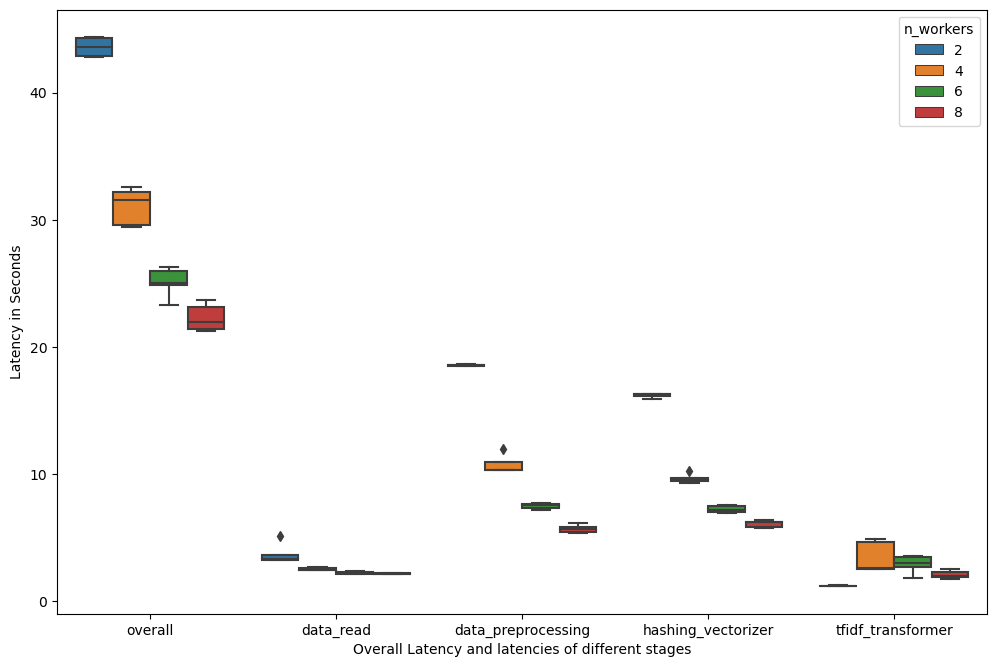

In [9]:
data, melt_data = visualize_data(result_path)        

In [10]:
groupby = data.groupby("n_workers").agg(['mean', 'std', 'count'])

In [11]:
groupby

overall                 data_read                  \
                mean       std count      mean       std count   
n_workers                                                        
2          43.601849  0.733715     5  3.676809  0.804110     5   
4          31.045885  1.455146     5  2.499536  0.111701     5   
6          25.068612  1.169822     5  2.190867  0.093679     5   
8          22.267771  1.096895     5  2.142816  0.053349     5   

          hashing_vectorizer                 tfidf_transformer  ...        \
                        mean       std count              mean  ... count   
n_workers                                                       ...         
2                  16.154609  0.174656     5          1.182243  ...     5   
4                   9.627595  0.377252     5          3.407960  ...     5   
6                   7.196249  0.276245     5          2.872289  ...     5   
8                   6.060744  0.278152     5          2.058753  ...     5   

          data_preprocessing                     nrows            sample_run  \
                        mean       std count      mean  std count       mean   
n_workers                                                                      
2                  18.526173  0.046918     5  20725971  0.0     5          2   
4                  10.764249  0.710378     5  20725971  0.0     5          2   
6                   7.466962  0.227338     5  20725971  0.0     5          2   
8                   5.670149  0.347658     5  20725971  0.0     5          2   

                           
                std count  
n_workers                  
2          1.581139     5  
4          1.581139     5  
6          1.581139     5  
8          1.581139     5  

[4 rows x 21 columns]

In [12]:
client.close()
cluster.close()